In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Load in the data

In [68]:
streamflow_data = pd.read_csv("data/streamflow_data/Final_Processed_Station_Data_Watershed.csv")
streamflow_data.dropna(inplace=True)
streamflow_data.head(5)

C:\Users\tbwil\AppData\Local\Temp\ipykernel_10476\1023125811.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241) have mixed types. Specify dtype option on import or

,name,ADAMS RIVER NEAR SQUILAX,ALOUETTE RIVER NEAR HANEY,ANDERSON CREEK NEAR NELSON,ANSEDAGAN CREEK NEAR NEW AIYANSH,ARROW CREEK NEAR ERICKSON,ASH RIVER BELOW MORAN CREEK,ASHNOLA RIVER NEAR KEREMEOS,ATNARKO RIVER NEAR THE MOUTH,BABINE RIVER AT OUTLET OF NILKITKWA LAKE,...,VANCE CREEK BELOW DEAFIES CREEK,VASEUX CREEK ABOVE SOLCO CREEK,VERNON CREEK AT OUTLET OF KALAMALKA LAKE,WANNOCK RIVER AT OUTLET OF OWIKENO LAKE,WEST CREEK NEAR FORT LANGLEY,WEST KETTLE RIVER AT WESTBRIDGE,WEST KETTLE RIVER NEAR MCCULLOCH,WHITEMAN CREEK ABOVE BOULEAU CREEK,YALAKOM RIVER ABOVE ORE CREEK,ZEBALLOS RIVER AT MOOK PEAK
0,lat,50.93759,49.239,49.50195,55.12986,49.15912,49.36992,49.20763,52.36008,55.42654,...,50.28432,49.24928,50.23847,51.67917,49.14767,49.16981,49.70292,50.21222,50.91261,50.13569
1,lon,-119.65634,-122.57975,-117.26128,-129.35494,-116.45249,-124.98411,-119.99352,-126.00586,-126.69763,...,-118.94704,-119.32139,-119.26689,-127.17917,-122.53187,-118.97506,-119.09247,-119.53861,-122.23931,-126.82006
2,major_watershed,South Thompson River,Fraser River,Lower Kootenay River,Nass River,Lower Kootenay River,Vancouver Island (West) Rivers,Okanagan River,North Coast Rivers,Babine River,...,South Thompson River,Okanagan River,Okanagan River,North Coast Rivers,Fraser River,Kettle River,Kettle River,Okanagan River,Fraser River,Vancouver Island (West) Rivers
3,2011-01-01,21.10065052,3.950658369,0.026633333,0.175258698,0.49568895,12.29111538,1.690907985,-126.00586,15.4966629,...,0.067015878,0.083,0.075272787,99.95522759,0.072746181,1.596026005,0.401,0.04718573,1.238667116,0.176193638
4,2011-01-02,20.69611806,3.74086273,0.0249375,0.163091831,0.485078758,11.49209615,1.755803793,-120.3616256,15.25197908,...,0.067070577,0.081,0.07749122,94.00841842,0.052530297,1.552300933,0.392296896,0.047,1.195453978,0.147495593


In [69]:
station_lats = streamflow_data.iloc[0][1:]
station_lons = streamflow_data.iloc[1][1:]
watersheds = streamflow_data.iloc[2][1:]

# drop the first 3 rows
streamflow_data = streamflow_data.drop([0, 1, 2])
# drop the first column
streamflow_data = streamflow_data.drop(columns=["name"])
streamflow_data = streamflow_data.astype(float)
streamflow_data.head(5)

,ADAMS RIVER NEAR SQUILAX,ALOUETTE RIVER NEAR HANEY,ANDERSON CREEK NEAR NELSON,ANSEDAGAN CREEK NEAR NEW AIYANSH,ARROW CREEK NEAR ERICKSON,ASH RIVER BELOW MORAN CREEK,ASHNOLA RIVER NEAR KEREMEOS,ATNARKO RIVER NEAR THE MOUTH,BABINE RIVER AT OUTLET OF NILKITKWA LAKE,BAKER CREEK AT QUESNEL,...,VANCE CREEK BELOW DEAFIES CREEK,VASEUX CREEK ABOVE SOLCO CREEK,VERNON CREEK AT OUTLET OF KALAMALKA LAKE,WANNOCK RIVER AT OUTLET OF OWIKENO LAKE,WEST CREEK NEAR FORT LANGLEY,WEST KETTLE RIVER AT WESTBRIDGE,WEST KETTLE RIVER NEAR MCCULLOCH,WHITEMAN CREEK ABOVE BOULEAU CREEK,YALAKOM RIVER ABOVE ORE CREEK,ZEBALLOS RIVER AT MOOK PEAK
3,21.100651,3.950658,0.026633,0.175259,0.495689,12.291115,1.690908,-126.005860,15.496663,0.779153,...,0.067016,0.083,0.075273,99.955228,0.072746,1.596026,0.401000,0.047186,1.238667,0.176194
4,20.696118,3.740863,0.024938,0.163092,0.485079,11.492096,1.755804,-120.361626,15.251979,0.777872,...,0.067071,0.081,0.077491,94.008418,0.052530,1.552301,0.392297,0.047000,1.195454,0.147496
5,20.412194,3.620703,0.023571,0.166408,0.486131,10.892279,1.819793,-114.717391,15.246768,0.772798,...,0.067069,0.079,0.079711,87.546224,0.036934,1.541753,0.383060,0.061246,1.150701,0.136078
6,20.203941,3.528421,0.024729,0.178720,0.498147,10.455154,1.879251,-109.073157,15.616654,0.768037,...,0.067029,0.077,0.082849,82.198203,0.035229,1.570497,0.373180,0.066975,1.107009,0.183736
7,20.193618,5.366124,0.024850,0.188595,0.509200,11.024510,1.930552,-103.428922,16.034901,0.763594,...,0.066954,0.075,0.087453,85.333824,0.458728,1.617611,0.362546,0.063745,1.066981,2.734586


In [70]:
# load in the precipitation and temperature data
rainfall_data = np.load("data/weather_data/rainfall_data.npy").astype(float)
snowfall_data = np.load("data/weather_data/snowfall_data.npy").astype(float)
max_temp_data = np.load("data/weather_data/max_temp_data_interp.npy").astype(float)
min_temp_data = np.load("data/weather_data/min_temp_data_interp.npy").astype(float)

# Split the data into training, validation, and test sets

In [71]:
# standardize the data
rainfall_data = (rainfall_data - np.mean(rainfall_data)) / np.std(rainfall_data)
snowfall_data = (snowfall_data - np.mean(snowfall_data)) / np.std(snowfall_data)
max_temp_data = (max_temp_data - np.mean(max_temp_data)) / np.std(max_temp_data)
min_temp_data = (min_temp_data - np.mean(min_temp_data)) / np.std(min_temp_data)
streamflow_data = (streamflow_data - streamflow_data.mean()) / streamflow_data.std()
streamflow_data = streamflow_data.to_numpy()

In [72]:
# define the fractions
train_frac = 7/9
val_frac = 1/9
test_frac = 1/9

assert train_frac + val_frac + test_frac == 1

# define the indices for the train, validation, and test sets
train_idx = int(train_frac * len(streamflow_data))
val_idx = int((train_frac + val_frac) * len(streamflow_data))
n_train = train_idx
n_val = val_idx - train_idx
n_test = len(streamflow_data) - val_idx

assert n_train + n_val + n_test == len(streamflow_data)

# standardize the data based on the training set
# rainfall_data = (rainfall_data - np.mean(rainfall_data[:train_idx])) / np.std(rainfall_data[:train_idx])
# snowfall_data = (snowfall_data - np.mean(snowfall_data[:train_idx])) / np.std(snowfall_data[:train_idx])
# max_temp_data = (max_temp_data - np.mean(max_temp_data[:train_idx])) / np.std(max_temp_data[:train_idx])
# min_temp_data = (min_temp_data - np.mean(min_temp_data[:train_idx])) / np.std(min_temp_data[:train_idx])
# streamflow_data = (streamflow_data - streamflow_data.iloc[:train_idx].mean()) / streamflow_data.iloc[:train_idx].std()
# streamflow_data = streamflow_data.to_numpy()

In [44]:
# define the time window
n_groups = 13
group_size = 14
time_window = n_groups * group_size
n_channels = 1
grid_shape = rainfall_data.shape[1:]
n_stations = streamflow_data.shape[1]

combine_multiple_groups = False
if combine_multiple_groups:
    pts_per_group = 7
    group_sizes = [1,7,14,30]
    n_groups = len(group_sizes) * pts_per_group
    time_window = np.sum(group_sizes) * pts_per_group
    start_idxs = np.cumsum([0] + [pts_per_group * size for size in group_sizes])

# create the training, validation, and test sets
x_intermediate = np.empty(np.shape(rainfall_data) + (4,), dtype='single')
for i, data in enumerate([rainfall_data, snowfall_data, max_temp_data, min_temp_data]):
    x_intermediate[:,:,:,i] = data
x_intermediate = x_intermediate[:,:,:,:n_channels]

def gen_train():
    for i in range(n_train - time_window):
        if combine_multiple_groups:
            xsizes = [x_intermediate[i+start_idxs[j]:i+start_idxs[j+1]].reshape(pts_per_group, *grid_shape, n_channels, group_sizes[j]).mean(axis=-1) for j in range(len(group_sizes))]
            xx = np.concatenate(xsizes, axis=0)
        else:
            xx = tf.convert_to_tensor(x_intermediate[i:i+time_window].reshape(n_groups, *grid_shape, n_channels, group_size).mean(axis=-1))
        yy = streamflow_data[time_window + i,:]
        yield (xx, yy)

def gen_val():
    for i in range(n_val):
        if combine_multiple_groups:
            xsizes = [x_intermediate[i+n_train-time_window+start_idxs[j]:i+n_train-time_window+start_idxs[j+1]].reshape(pts_per_group, *grid_shape, n_channels, group_sizes[j]).mean(axis=-1) for j in range(len(group_sizes))]
            xx = np.concatenate(xsizes, axis=0)
        else:
            xx = tf.convert_to_tensor(x_intermediate[i+n_train-time_window:i+n_train].reshape(n_groups, *grid_shape, n_channels, group_size).mean(axis=-1))
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

def gen_test():
    for i in range(n_test):
        if combine_multiple_groups:
            xsizes = [x_intermediate[i+val_idx-time_window+start_idxs[j]:i+val_idx+start_idxs[j+1]].reshape(pts_per_group, *grid_shape, n_channels, group_sizes[j]).mean(axis=-1) for j in range(len(group_sizes))]
            xx = np.concatenate(xsizes, axis=0)
        else:
            xx = tf.convert_to_tensor(x_intermediate[i+val_idx-time_window:i+val_idx].reshape(n_groups, *grid_shape, n_channels, group_size).mean(axis=-1))
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

# Create a model

In [102]:
def create_model(learning_rate=0.001):
    # Input layer
    cnn_input = layers.Input(shape=(n_groups, *grid_shape, n_channels), name="Weather_Data_Input")
    
    # TimeDistributed CNN
    cnn = layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))(cnn_input)
    cnn = layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))(cnn)
    cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)
    cnn = layers.TimeDistributed(layers.Flatten())(cnn)  # Flatten the grid

    # LSTM for temporal patterns
    lstm = layers.LSTM(32, return_sequences=False)(cnn)

    # Fully connected layers
    dense = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(lstm)
    dense = layers.Dropout(0.4)(dense)  # Dropout for regularization
    output = layers.Dense(n_stations, activation='linear', name="Streamflow_Output")(dense)

    # Model definition
    model = models.Model(inputs=cnn_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

model = create_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Weather_Data_Input (InputLayer) │ (None, 60, 22, 37, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 60, 22, 37, 8)  │           296 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 60, 22, 37, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 60, 11, 18, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 60, 3168)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Streamflow_Output (Dense)       │ (None, 241)            │        15,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,969 (1.64 MB)

 Trainable params: 428,969 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

### Model rationale:
Lighter Convolutions:
* Starting with 8 filters in the first Conv2D reduces computational overhead while still extracting features.

Pooling for Dimensionality Reduction:
* The MaxPooling2D layer halves spatial dimensions, reducing memory and compute needs.

Flatten Instead of Global Pooling:
* Retains more detailed spatial features by flattening instead of directly aggregating with GlobalMaxPooling2D.

Single LSTM Layer:
* A single LSTM with 64 units balances complexity and efficiency.

Dropout Regularization:
* A dropout rate of 0.2 in the dense layers mitigates overfitting without significant computational cost.

Simplified Dense Layers:
* One hidden layer in the Dense block keeps the architecture compact.

In [104]:
# visualize the model
tf.keras.utils.plot_model(
    model, 
    to_file="model_architecture.png",  # Save the diagram as an image file
    show_shapes=True,  # Display tensor shapes in the diagram
    show_layer_names=True,  # Display layer names
    dpi=96  # Resolution of the image
)

AttributeError: module 'pydot' has no attribute 'PydotException'

# Train and save the model

In [46]:
batch_size = 16
learning_rate = 0.001
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=10,
                                             restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.1,
                                                patience=5,
                                                verbose=1,
                                                mode='min')

print(f"Training model with {group_size} day groups and {n_groups} groups")
print(f"Using {n_channels} data channels")
train_dataset = tf.data.Dataset.from_generator(
    gen_train,
    (tf.float16, tf.float16),
    (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).shuffle(n_train).batch(batch_size)

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).shuffle(n_val).batch(batch_size)

model = create_model(learning_rate)
model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1,
    # callbacks=[early_stopping, reduce_lr]
    callbacks=[reduce_lr]
)

# save the model
if combine_multiple_groups:
    model.save(f"models/test_model_composite_{n_channels}ch.keras")
model.save(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

Training model with 14 day groups and 13 groups
Using 1 data channels
Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - loss: 1.1905 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - loss: 0.6121 - val_loss: 0.4482 - learning_rate: 0.0010
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - loss: 0.4877 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.4368 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 0.4102 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.3729
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.3730 - val_loss: 0.4728 - learning_rate: 0.0010
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.3747 - val_loss: 0.4417 - learning_rate: 1.0000e-04


# Plot the results

In [14]:
def compute_nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step


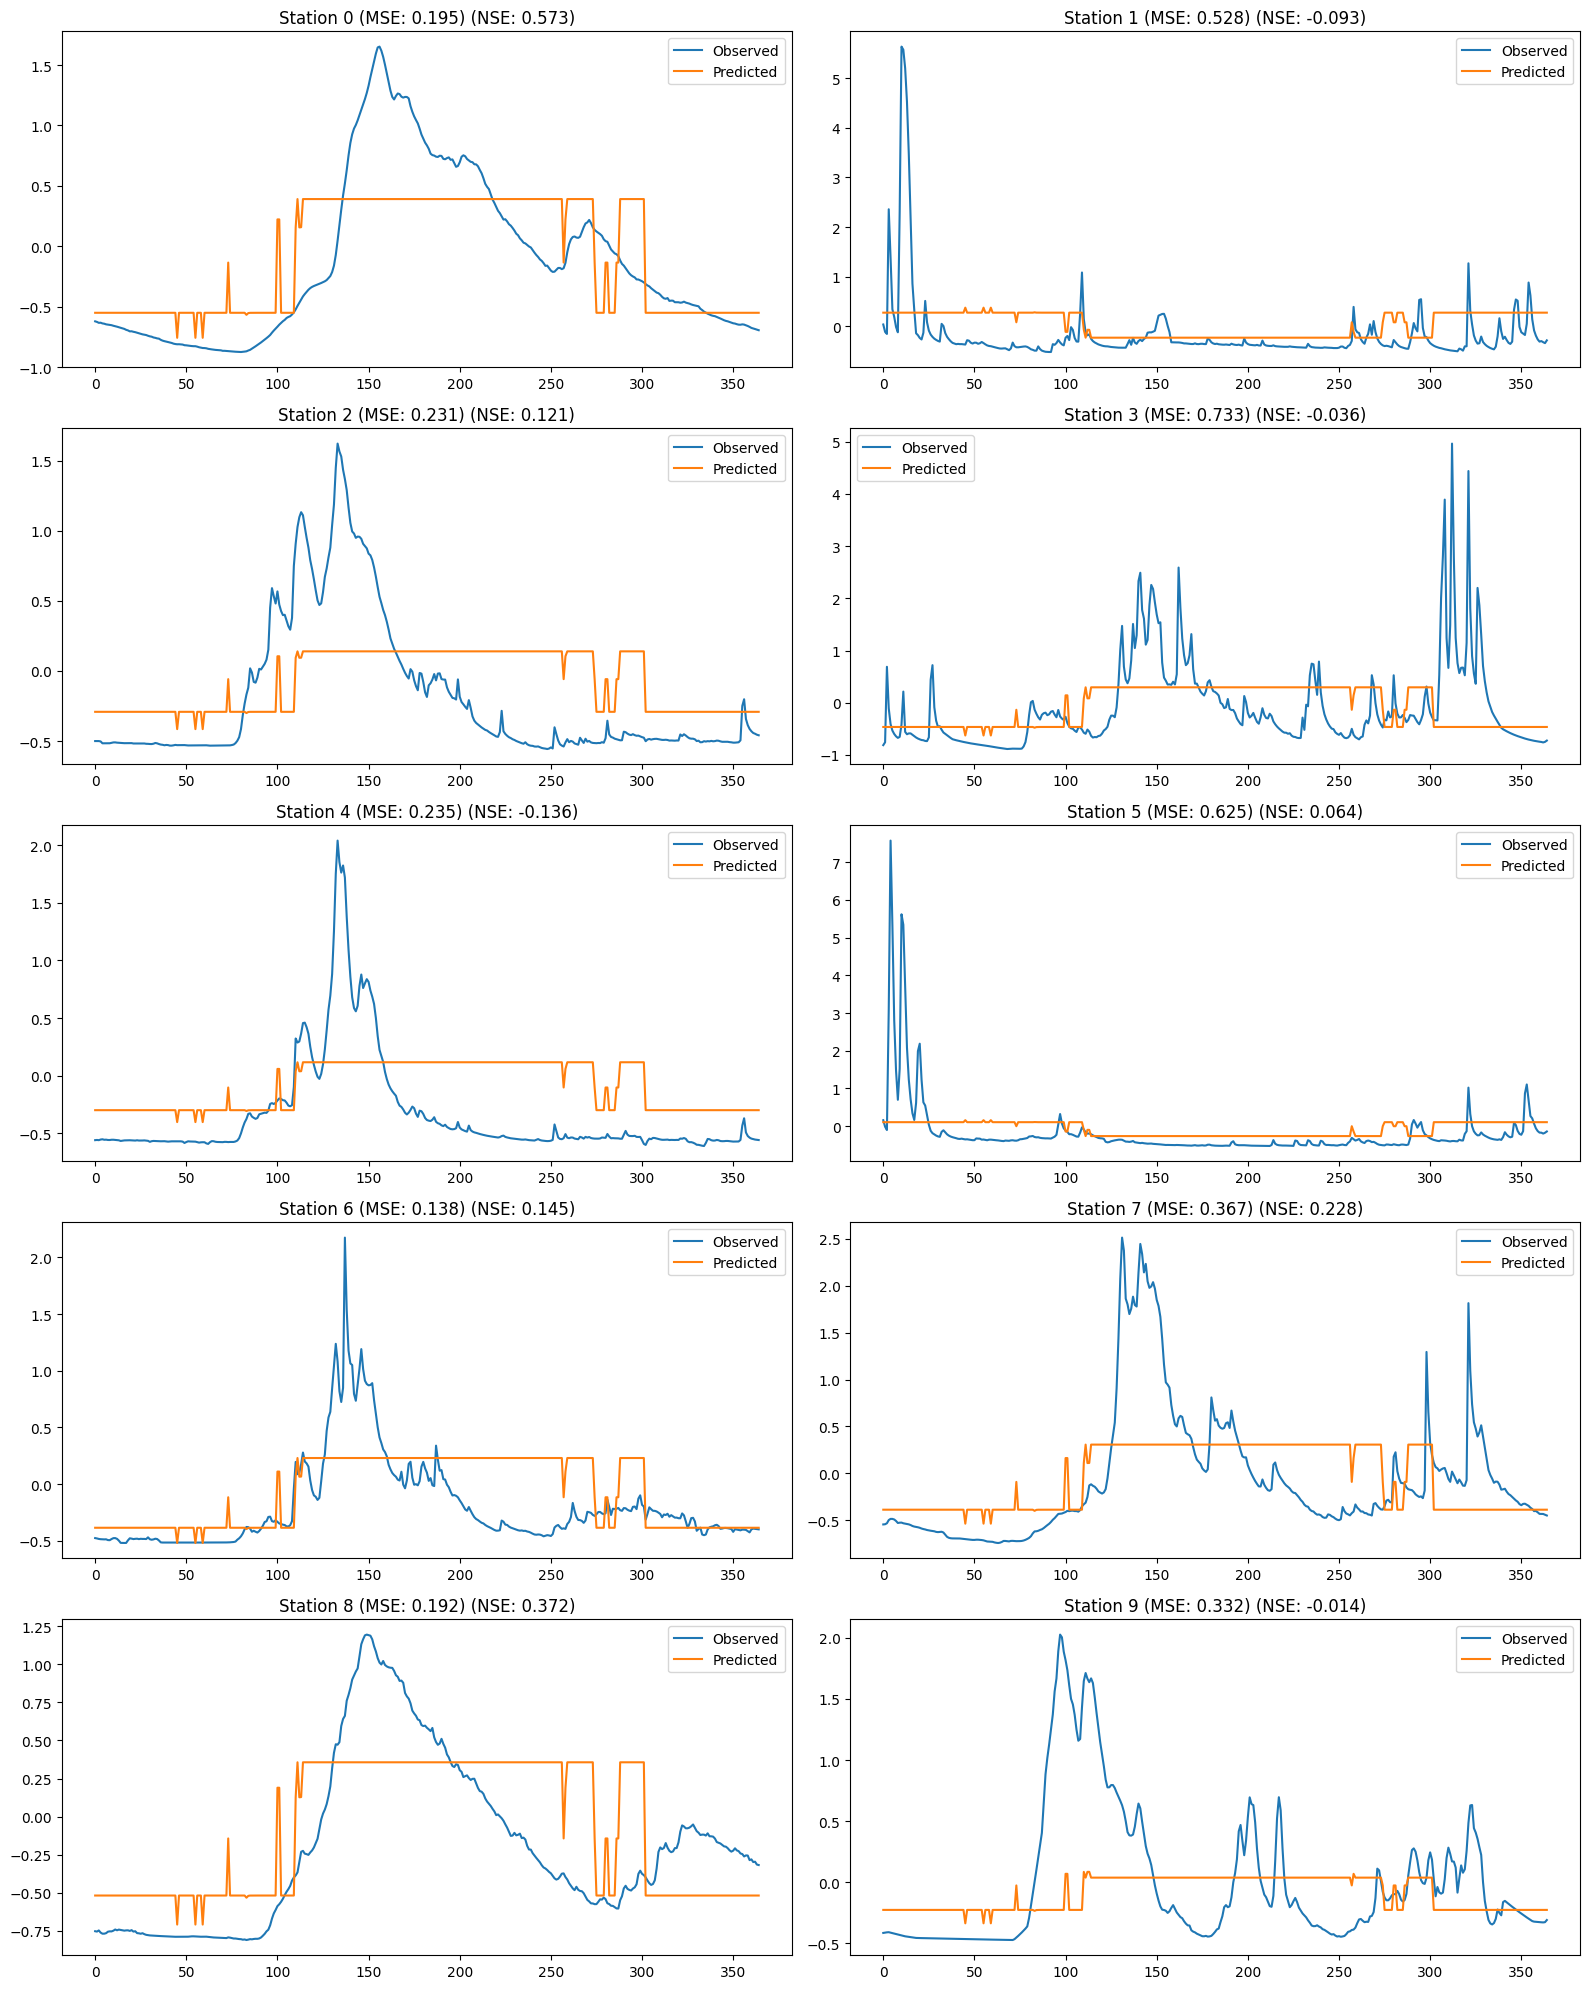

In [81]:
# plot the model predictions for the first 20 stations using subplots
n_plot = 10

batch_size = 16
n_groups = 60
group_size = 1
time_window = n_groups * group_size
n_channels = 4

x_intermediate = np.empty(np.shape(rainfall_data) + (4,), dtype='single')
for i, data in enumerate([rainfall_data, snowfall_data, max_temp_data, min_temp_data]):
    x_intermediate[:,:,:,i] = data
x_intermediate = x_intermediate[:,:,:,:n_channels]

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).batch(batch_size)

if combine_multiple_groups:
    model = tf.keras.models.load_model(f"models/test_model_composite_{n_channels}ch.keras")
else:
    model = tf.keras.models.load_model(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

predictions = model.predict(val_dataset)
y_true = np.empty((n_val, n_stations))
for i, (_, y) in enumerate(gen_val()):
    y_true[i] = y

fig, axs = plt.subplots(n_plot // 2, 2, figsize=(16, n_plot * 2))
for i in range(n_plot):
    mse = np.mean((y_true[:, i] - predictions[:, i]) ** 2)
    nse = compute_nse(y_true[:, i], predictions[:, i])
    station = i
    ax = axs[i // 2, i % 2]
    ax.plot(y_true[:, station], label='Observed')
    ax.plot(predictions[:, station], label='Predicted')
    ax.set_title(f"Station {station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
    ax.legend()
plt.tight_layout()
plt.show()

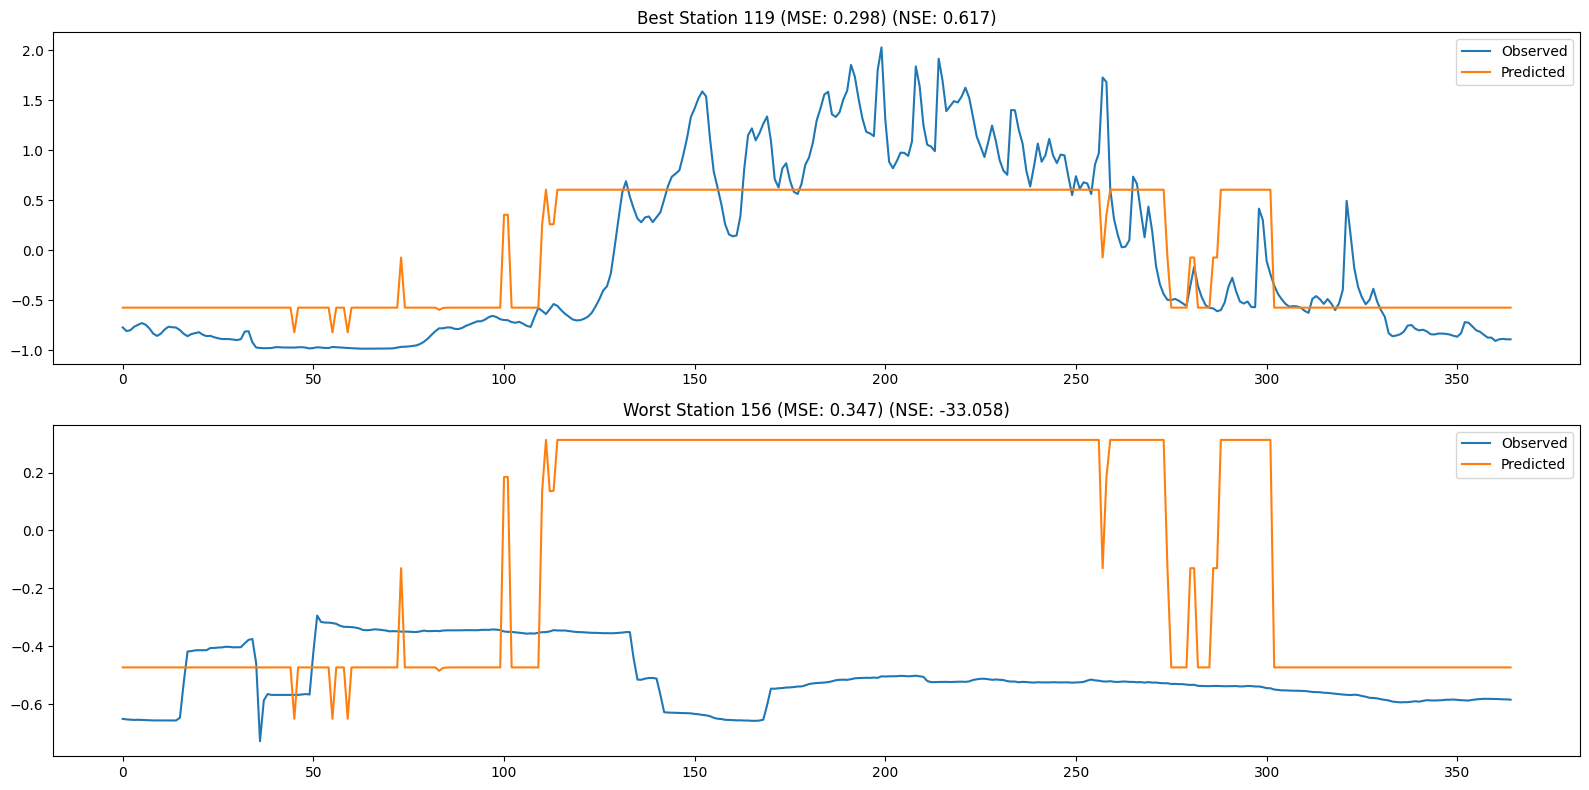

Mean NSE: -0.179


In [82]:
# plot the best and worst predictions by NSE
best_station = np.argmax([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])
worst_station = np.argmin([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])

# best_station = np.argmin(np.mean((y_true - predictions) ** 2, axis=0))
# worst_station = np.argmax(np.mean((y_true - predictions) ** 2, axis=0))

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
mse = np.mean((y_true[:, best_station] - predictions[:, best_station]) ** 2)
nse = compute_nse(y_true[:, best_station], predictions[:, best_station])
axs[0].plot(y_true[:, best_station], label='Observed')
axs[0].plot(predictions[:, best_station], label='Predicted')
axs[0].set_title(f"Best Station {best_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[0].legend()

mse = np.mean((y_true[:, worst_station] - predictions[:, worst_station]) ** 2)
nse = compute_nse(y_true[:, worst_station], predictions[:, worst_station])
axs[1].plot(y_true[:, worst_station], label='Observed')
axs[1].plot(predictions[:, worst_station], label='Predicted')
axs[1].set_title(f"Worst Station {worst_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[1].legend()
plt.tight_layout()
plt.show()

# print the mean NSE
mean_nse = np.mean([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])
print(f"Mean NSE: {mean_nse:.3f}")

# Plot the test model performances

In [78]:
# collect all of the test_model_group files
import os
import re

model_files = [f for f in os.listdir("models") if f.startswith("test_model_group")]

# extract the group size, number of groups, and number of channels from the file name
model_info = []
for model_file in model_files:
    group_size, n_groups, n_channels = [int(s) for s in re.findall(r'\d+', model_file)]
    if n_channels == 4:
        model_info.append((group_size, n_groups, n_channels))

# load the models and compute the predictions
predictions = []
y_true = []
mean_mse = []
mean_nse = []
for (group_size, n_groups, n_channels) in model_info:
    time_window = n_groups * group_size
    val_dataset = tf.data.Dataset.from_generator(
        gen_val,
        (tf.float16, tf.float16),
        (tf.TensorShape([n_groups, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).batch(batch_size)

    model = tf.keras.models.load_model(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

    predictions.append(model.predict(val_dataset))
    y_true.append(np.array([y for _, y in gen_val()]))
    mean_mse.append(np.mean((y_true[-1] - predictions[-1]) ** 2))
    mean_nse.append(np.mean([compute_nse(y_true[-1][:, i], predictions[-1][:, i]) for i in range(n_stations)]))

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step


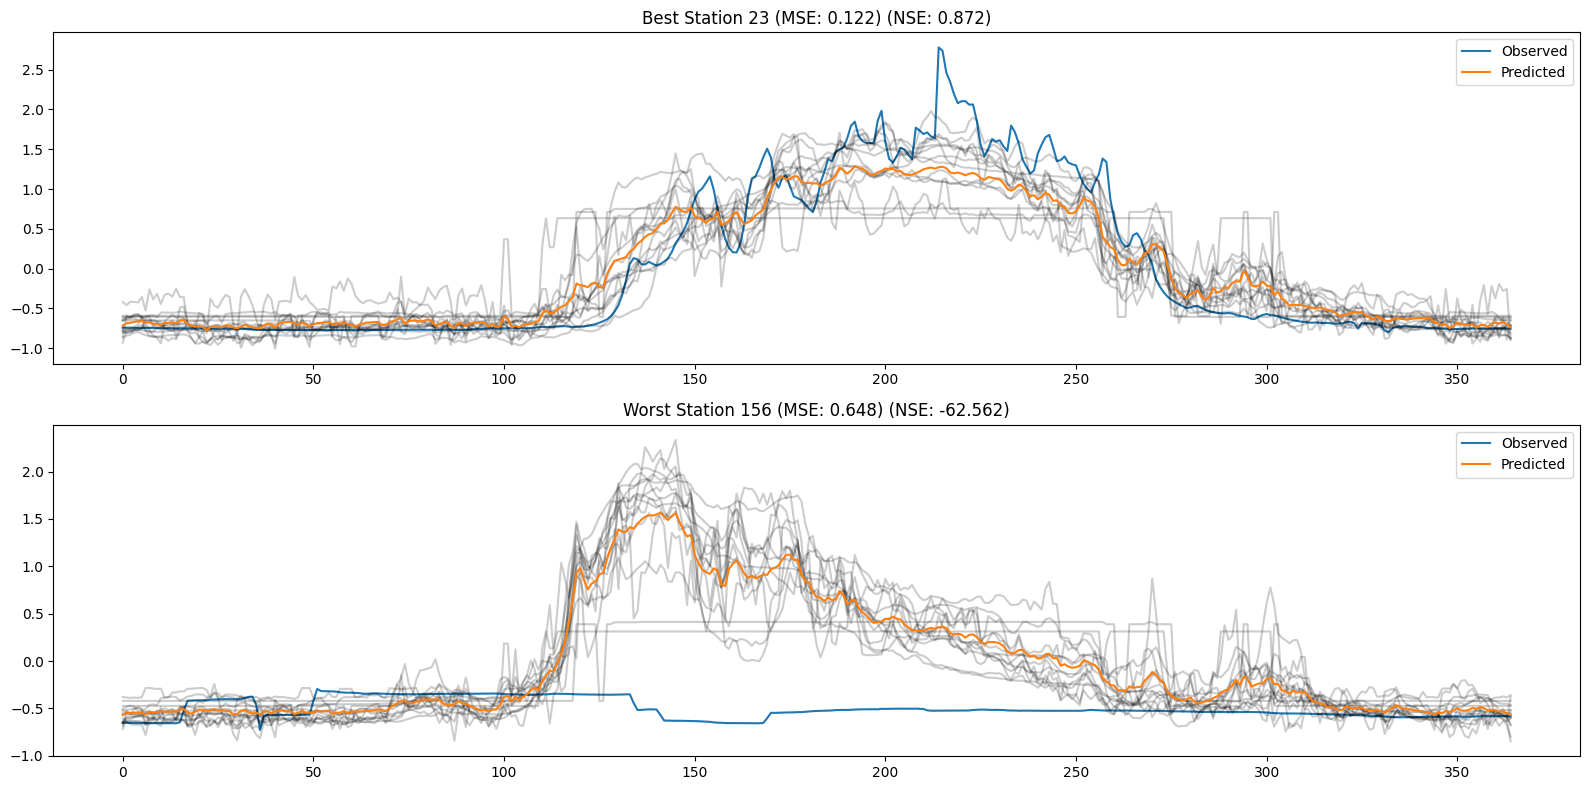

0.40488929181464384


In [76]:
# plot the average prediction as an ensemble
ensemble_predictions = np.mean(predictions, axis=0)
ensemble_mse = np.mean((y_true[0] - ensemble_predictions) ** 2)
ensemble_nse = compute_nse(y_true[0], ensemble_predictions)

# plot the best and worst predictions by NSE
best_station = np.argmax([compute_nse(y_true[0][:, i], ensemble_predictions[:, i]) for i in range(n_stations)])
worst_station = np.argmin([compute_nse(y_true[0][:, i], ensemble_predictions[:, i]) for i in range(n_stations)])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
mse = np.mean((y_true[0][:, best_station] - ensemble_predictions[:, best_station]) ** 2)
nse = compute_nse(y_true[0][:, best_station], ensemble_predictions[:, best_station])
axs[0].plot(y_true[0][:, best_station], label='Observed')
axs[0].plot(np.array(predictions).T[best_station], c='k', alpha=0.2)
axs[0].plot(ensemble_predictions[:, best_station], label='Predicted')
axs[0].set_title(f"Best Station {best_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[0].legend()

mse = np.mean((y_true[0][:, worst_station] - ensemble_predictions[:, worst_station]) ** 2)
nse = compute_nse(y_true[0][:, worst_station], ensemble_predictions[:, worst_station])
axs[1].plot(y_true[0][:, worst_station], label='Observed')
axs[1].plot(np.array(predictions).T[worst_station], c='k', alpha=0.2)
axs[1].plot(ensemble_predictions[:, worst_station], label='Predicted')
axs[1].set_title(f"Worst Station {worst_station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
axs[1].legend()
plt.tight_layout()
plt.show()

# print the mean NSE
print(ensemble_nse)

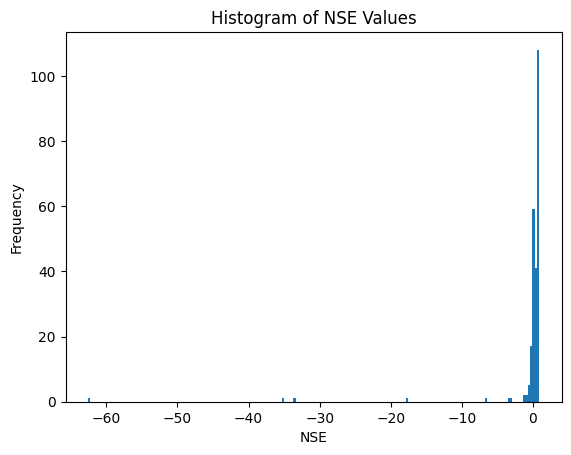

In [95]:
# create a histogram of the NSE values
y_true_arr = np.array(y_true)
nse_per_station = np.array([compute_nse(y_true[:,i], ensemble_predictions[:, i]) for i in range(n_stations)])
plt.hist(nse_per_station, bins=200)
plt.title("Histogram of NSE Values")
plt.xlabel("NSE")
plt.ylabel("Frequency")
plt.show()

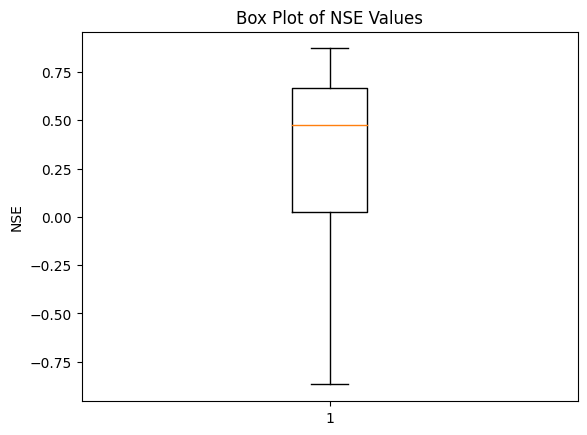

In [98]:
# create a box plot without outliers
plt.boxplot(nse_per_station, showfliers=False)
plt.title("Box Plot of NSE Values")
plt.ylabel("NSE")
plt.show()

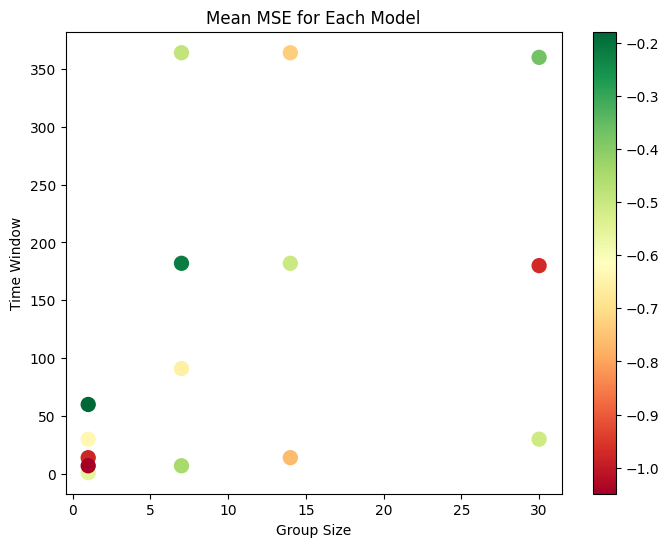

In [80]:
# plot a heatmap of the mean NSE for each model
group_sizes = [group_size for group_size, _, _ in model_info]
time_windows = [group_size * n_groups for group_size, n_groups, _ in model_info]

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(group_sizes, time_windows, c=mean_nse, cmap='RdYlGn', s=100)
plt.xlabel("Group Size")
plt.ylabel("Time Window")
plt.title("Mean MSE for Each Model")
plt.colorbar()
plt.show()

# Create a composite model looking at different time windows

In [ ]:
# define the time window
n_channels = 4
grid_shape = rainfall_data.shape[1:]
n_stations = streamflow_data.shape[1]

pts_per_group = 7
group_sizes = [1,7,14,30]
max_time_window = group_sizes[-1] * pts_per_group

# create the training, validation, and test sets
x_intermediate = np.empty(np.shape(rainfall_data) + (4,), dtype='single')
for i, data in enumerate([rainfall_data, snowfall_data, max_temp_data, min_temp_data]):
    x_intermediate[:,:,:,i] = data
x_intermediate = x_intermediate[:,:,:,:n_channels]

def gen_train():
    for i in range(n_train - max_time_window):
        xsizes = [x_intermediate[i:i+group_size*pts_per_group].reshape(pts_per_group, *grid_shape, n_channels, group_size).mean(axis=-1) for group_size in group_sizes]
        xx = tf.convert_to_tensor(np.stack(xsizes, axis=-1))
        yy = streamflow_data[time_window + i,:]
        yield (xx, yy)

def gen_val():
    for i in range(n_val):
        xsizes = [x_intermediate[i+n_train-group_size*pts_per_group:i+n_train].reshape(pts_per_group, *grid_shape, n_channels, group_size).mean(axis=-1) for group_size in group_sizes]
        xx = tf.convert_to_tensor(np.stack(xsizes, axis=-1))
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

def gen_test():
    for i in range(n_test):
        xsizes = [x_intermediate[i+val_idx-group_size*pts_per_group:i+val_idx].reshape(pts_per_group, *grid_shape, n_channels, group_size).mean(axis=-1) for group_size in group_sizes]
        xx = tf.convert_to_tensor(np.stack(xsizes, axis=-1))
        yy = streamflow_data[val_idx + i,:]
        yield (xx, yy)

In [290]:
def create_model(learning_rate=0.001):
    # Input layer
    cnn_input = layers.Input(shape=(pts_per_group, *grid_shape, n_channels, len(group_sizes)), name="Weather_Data_Input")

    # Split the input into daily, weekly, and monthly components
    daily_input = layers.Lambda(lambda x: x[..., 0], name="Daily_Input")(cnn_input)
    weekly_input = layers.Lambda(lambda x: x[..., 1], name="Weekly_Input")(cnn_input)
    biweekly_input = layers.Lambda(lambda x: x[..., 2], name="Biweekly_Input")(cnn_input)
    monthly_input = layers.Lambda(lambda x: x[..., 3], name="Monthly_Input")(cnn_input)

    # Shared CNN block for all timescales
    def cnn_block(input_layer):
        cnn = layers.TimeDistributed(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))(input_layer)
        cnn = layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))(cnn)
        cnn = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(cnn)
        cnn = layers.TimeDistributed(layers.Flatten())(cnn)  # Flatten the grid
        return cnn

    # Apply CNN block to each timescale
    daily_features = cnn_block(daily_input)
    weekly_features = cnn_block(weekly_input)
    biweekly_features = cnn_block(biweekly_input)
    monthly_features = cnn_block(monthly_input)

    # Concatenate features from all timescales
    combined_features = layers.Concatenate(name="Combined_Features")(
        [daily_features, weekly_features, biweekly_features, monthly_features]
    )

    # LSTM for temporal patterns
    lstm = layers.LSTM(32, return_sequences=False)(combined_features)

    # Fully connected layers
    dense = layers.Dense(64, activation='relu')(lstm)
    dense = layers.Dropout(0.2)(dense)  # Dropout for regularization
    output = layers.Dense(n_stations, activation='linear', name="Streamflow_Output")(dense)

    # Model definition
    model = models.Model(inputs=cnn_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Instantiate and summarize the model
model = create_model()
model.summary()


Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Weather_Data_Input  │ (None, 7, 22, 37, │          0 │ -                 │
│ (InputLayer)        │ 4, 4)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Daily_Input         │ (None, 7, 22, 37, │          0 │ Weather_Data_Inp… │
│ (Lambda)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Weekly_Input        │ (None, 7, 22, 37, │          0 │ Weather_Data_Inp… │
│ (Lambda)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Biweekly_Input      │ (None, 7, 22, 37, │          0 │ Weather_Data_Inp… │
│ (Lambda)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Monthly_Input       │ (None, 7, 22, 37, │          0 │ Weather_Data_Inp… │
│ (Lambda)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3… │ (None, 7, 22, 37, │        296 │ Daily_Input[0][0] │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │        296 │ Weekly_Input[0][… │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │        296 │ Biweekly_Input[0… │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │        296 │ Monthly_Input[0]… │
│ (TimeDistributed)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │      1,168 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │      1,168 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │      1,168 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 22, 37, │      1,168 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 11, 18, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 11, 18, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 11, 18, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4… │ (None, 7, 11, 18, │          0 │ time_distributed

 Total params: 1,649,873 (6.29 MB)

 Trainable params: 1,649,873 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 8
learning_rate = 0.001
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=5,
                                             restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.5,
                                                patience=2,
                                                verbose=1,
                                                mode='min')

print(f"Training model with {group_size} day groups and {n_groups} groups")
print(f"Using {n_channels} data channels")
train_dataset = tf.data.Dataset.from_generator(
    gen_train,
    (tf.float16, tf.float16),
    (tf.TensorShape([pts_per_group, *grid_shape, n_channels, len(group_sizes)]), tf.TensorShape([n_stations]))
).shuffle(n_train).batch(batch_size)

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([pts_per_group, *grid_shape, n_channels, len(group_sizes)]), tf.TensorShape([n_stations]))
).shuffle(n_val).batch(batch_size)

model = create_model(learning_rate)
model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# save the model
if combine_multiple_groups:
    model.save(f"models/test_model_composite_{n_channels}ch.keras")
model.save(f"models/test_model_group_{group_size}x{n_groups}days_{n_channels}ch.keras")

Training model with 7 day groups and 28 groups
Using 4 data channels
Epoch 1/40
    294/Unknown 46s 108ms/step - loss: 0.7409

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


294/294 ━━━━━━━━━━━━━━━━━━━━ 50s 120ms/step - loss: 0.7405 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 2/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - loss: 0.4807 - val_loss: 0.6176 - learning_rate: 0.0010
Epoch 3/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - loss: 0.4627 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 4/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - loss: 0.4463 - val_loss: 0.8636 - learning_rate: 0.0010
Epoch 5/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.4434
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - loss: 0.4435 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 6/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - loss: 0.4272 - val_loss: 0.6266 - learning_rate: 1.0000e-04
Epoch 7/40
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.4221
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - lo

In [301]:
# compute the mean nse for this model
predictions = model.predict(val_dataset)
y_true = np.empty((n_val, n_stations))
for i, (_, y) in enumerate(gen_val()):
    y_true[i] = y
mean_nse = np.mean([compute_nse(y_true[:, i], predictions[:, i]) for i in range(n_stations)])

mean_nse

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


-0.5212402000453744

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


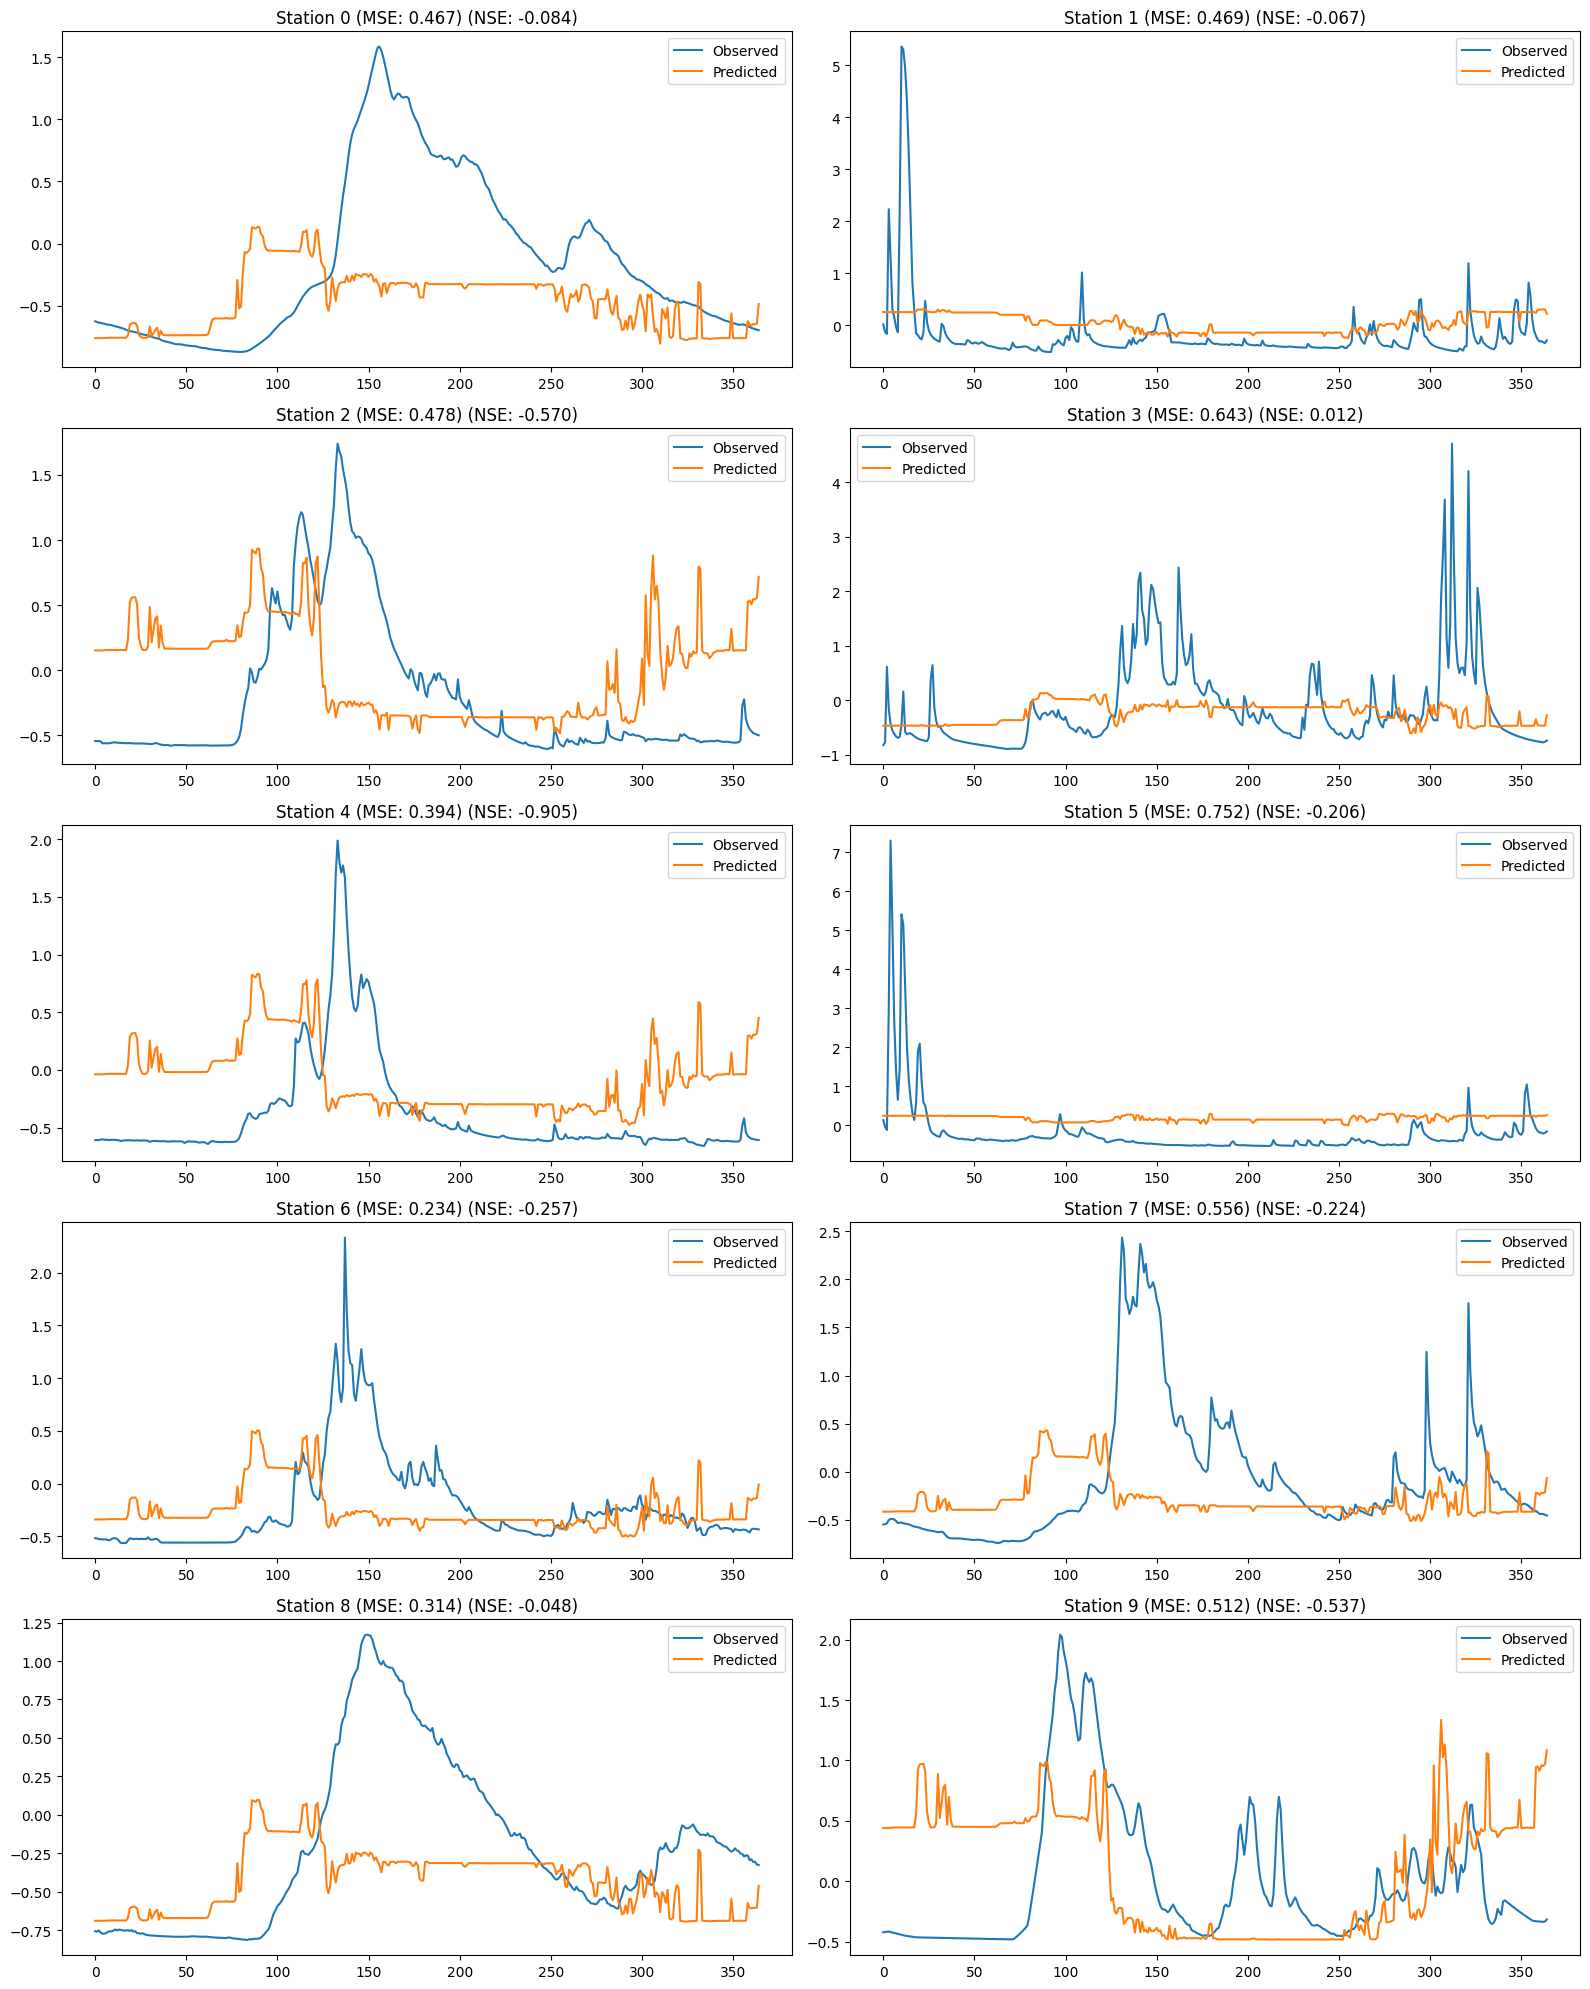

In [305]:
# plot the results for the first 10 stations
from keras.config import enable_unsafe_deserialization
enable_unsafe_deserialization()

n_plot = 10

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([pts_per_group, *grid_shape, n_channels, len(group_sizes)]), tf.TensorShape([n_stations]))
).batch(batch_size)

model = tf.keras.models.load_model(f"models/test_model_multichannel.keras")

predictions = model.predict(val_dataset)
y_true = np.empty((n_val, n_stations))
for i, (_, y) in enumerate(gen_val()):
    y_true[i] = y

fig, axs = plt.subplots(n_plot // 2, 2, figsize=(16, n_plot * 2))
for i in range(n_plot):
    mse = np.mean((y_true[:, i] - predictions[:, i]) ** 2)
    nse = compute_nse(y_true[:, i], predictions[:, i])
    station = i
    ax = axs[i // 2, i % 2]
    ax.plot(y_true[:, station], label='Observed')
    ax.plot(predictions[:, station], label='Predicted')
    ax.set_title(f"Station {station} (MSE: {mse:.3f}) (NSE: {nse:.3f})")
    ax.legend()
plt.tight_layout()
plt.show()

# Train an ensemble of the best model

In [ ]:
raise NotImplementedError("Best model not yet determined")

NotImplementedError: Best model not yet determined

In [ ]:
# create datasets and train an ensemble
batch_size = 8
ensemble_size = 10
learning_rate = 0.01

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             mode='min',
                                             verbose=1,
                                             patience=5,
                                             restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.1,
                                                patience=2,
                                                verbose=1,
                                                mode='min')

for i in range(ensemble_size):
    print(f"Training model {i+1}/{ensemble_size}")

    train_dataset = tf.data.Dataset.from_generator(
        gen_train,
        (tf.float16, tf.float16),
        (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).shuffle(n_train).batch(batch_size)

    val_dataset = tf.data.Dataset.from_generator(
        gen_val,
        (tf.float16, tf.float16),
        (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
    ).shuffle(n_val).batch(batch_size)

    model = create_model()
    model.fit(
        train_dataset,
        epochs=40,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[early_stopping, reduce_lr],
    )

    # save the model
    model.save(f"models/ensemble_model_{i}.keras")


In [ ]:
# evaluate the ensemble
ensemble = []
for i in range(4):
    model = tf.keras.models.load_model(f"models/ensemble_model_{i}.keras")
    ensemble.append(model)

val_dataset = tf.data.Dataset.from_generator(
    gen_val,
    (tf.float16, tf.float16),
    (tf.TensorShape([time_window, *grid_shape, n_channels]), tf.TensorShape([n_stations]))
).batch(batch_size)

ensemble_predictions = []
for model in ensemble:
    ensemble_predictions.append(model.predict(val_dataset))

ensemble_mean = np.mean(ensemble_predictions, axis=0)

# calculate the RMSE
val_data = np.zeros((n_val, n_stations))
for i, (xx, yy) in enumerate(gen_val()):
    val_data[i] = yy

In [ ]:
# plot the model predictions for the first 20 stations using subplots
n_plot = 20

predictions = ensemble_mean

fig, axs = plt.subplots(n_plot // 2, 2, figsize=(16, n_plot * 2))
for i in range(n_plot):
    mse = np.mean((val_data[:, i] - predictions[:, i]) ** 2)
    station = i
    ax = axs[i // 2, i % 2]
    ax.plot(np.array(ensemble_predictions).T[i], c='k', alpha=0.2)
    ax.plot(val_data[:, station], label='Actual')
    ax.plot(predictions[:, station], label='Predicted')
    ax.set_title(f"Station {station} (MSE: {mse:.3f})")
    ax.legend()
plt.tight_layout()
plt.show()